<a href="https://colab.research.google.com/github/mlelarge/dataflowr/blob/master/CEA_EDF_INRIA/bayes_by_backprop_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayes by backpropagation

notebook credit: [Nitarshan Rajkumar](https://www.nitarshan.com/bayes-by-backprop/)

In [0]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

from tensorboardX import SummaryWriter
writer = SummaryWriter('/home/docker_user/runs/bnn')

# sns.set()
# sns.set_style("dark")
# sns.set_palette("muted")
# sns.set_color_codes("muted")

In [0]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


## Data preparation

In [0]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 5 #20
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

0it [00:00, ?it/s]

26427392it [00:06, 4063166.39it/s]                              


Extracting ./fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 199163.22it/s]           
0it [00:00, ?it/s]

Extracting ./fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 2590511.84it/s]                              


Extracting ./fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 102299.49it/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...


Done!


## Modelling

<p>Calculating the expectation of the likelihood over the variational posterior is computationally prohibitive, so we (once more) will rely on an approximate method to determining it. We approximate our cost function using sampled weights:</p>

$\mathcal{F}(\mathcal{D}, \theta) \approx \sum_{i=1}^n{\log{q(\mathbf{w}^{(i)}\vert\theta)} - \log{P(\mathbf{w}^{(i)})} - \log{P(\mathcal{D}\vert\mathbf{w}^{(i)})}}$

<p>When using automatic differentiation as provided by frameworks such as PyTorch, we only need to worry about implementing this sampling, and setting up the cost function as above, and can leverage our usual backpropagation methods to train a model. The beauty of this algorithm is that it is a mathematically sound approximation for</p>

### Reparameterized Gaussian

$$\begin{aligned}
\theta &= (\mu, \rho)\\
\sigma &= \log{(1+e^\rho)}\\
\mathcal{N}(x\vert \mu, \sigma) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}\\
\log{\mathcal{N}(x\vert \mu, \sigma)} &= -\log{\sqrt{2\pi}} -\log{\sigma} -\frac{(x-\mu)^2}{2\sigma^2}\\
P(\mathbf{w}) &= \prod_j{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}\\
\log{P(\mathbf{w})} &= \sum_j{\log{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}}\\
\end{aligned}$$

In [0]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

Gaussian Scale Mixture Prior</h3>
<p>The authors suggest the use of a scaled mixture of two gaussians for the prior distribution on weights. Both gaussians are zero mean, but with separate variances. When setting $\sigma_1 \gt \sigma_2$ and $\sigma_2 \ll 1$, we obtain a spike-and-slab prior that combines a heavy tail ($\sigma_1$) with a concentration around the 0 mean ($\sigma_2$). Accordingly, this distribution’s probability function is as follows:</p>

$$
\begin{aligned}
P(\mathbf{w}) &= \prod_j{\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2)}\\
\log{P(\mathbf{w})} &= \sum_j{\log{(\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2))}}\\
\end{aligned} $$

<p>As the prior parameters are fixed and will not be modified in training, we don’t need to use a reparameterized Gaussian here:</p>

In [0]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

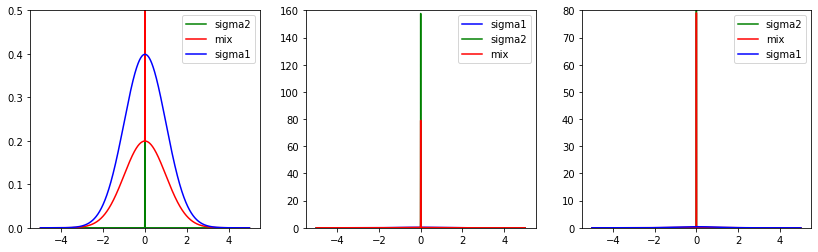

In [0]:
PI = 0.5
SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)])
SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)])

def visualize_scale_mixture_components():
    def show_lines():
        pass
    mix = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
    normal_1 = torch.distributions.Normal(0, SIGMA_1)
    normal_2 = torch.distributions.Normal(0, SIGMA_2)
    x_points = np.linspace(-5,5,10000)
    d1 = np.array([torch.exp(normal_1.log_prob(float(c))) for c in x_points])
    d2 = np.array([torch.exp(normal_2.log_prob(float(c))) for c in x_points])
    d3 = np.array([torch.exp(mix.log_prob(float(c))) for c in x_points])
    plt.subplots(1,3,figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,0.5)
    plt.subplot(1,3,2)
    plt.plot(x_points,d1,color="b")
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.legend(["sigma1", "sigma2", "mix"])
    plt.ylim(0,160)
    plt.subplot(1,3,3)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,80)
    
visualize_scale_mixture_components()

We now have all the components we need to construct a single bayesian network layer:

In [0]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

And can also construct the full 2-layer fully connected neural network model:

In [0]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = BayesianLinear(28*28, 400)
        self.l2 = BayesianLinear(400, 400)
        self.l3 = BayesianLinear(400, 10)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l2.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, reduction='sum')
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

net = BayesianNetwork().to(DEVICE)

## Training

Tensorboard is a useful tool for keeping track of evolution of training and network sanity

In [0]:
def write_weight_histograms(epoch):
    writer.add_histogram('histogram/w1_mu', net.l1.weight_mu,epoch)
    writer.add_histogram('histogram/w1_rho', net.l1.weight_rho,epoch)
    writer.add_histogram('histogram/w2_mu', net.l2.weight_mu,epoch)
    writer.add_histogram('histogram/w2_rho', net.l2.weight_rho,epoch)
    writer.add_histogram('histogram/w3_mu', net.l3.weight_mu,epoch)
    writer.add_histogram('histogram/w3_rho', net.l3.weight_rho,epoch)
    writer.add_histogram('histogram/b1_mu', net.l1.bias_mu,epoch)
    writer.add_histogram('histogram/b1_rho', net.l1.bias_rho,epoch)
    writer.add_histogram('histogram/b2_mu', net.l2.bias_mu,epoch)
    writer.add_histogram('histogram/b2_rho', net.l2.bias_rho,epoch)
    writer.add_histogram('histogram/b3_mu', net.l3.bias_mu,epoch)
    writer.add_histogram('histogram/b3_rho', net.l3.bias_rho,epoch)

def write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood):
    writer.add_scalar('logs/loss', loss, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/complexity_cost', log_variational_posterior-log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_prior', log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_variational_posterior', log_variational_posterior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch*NUM_BATCHES+batch_idx)

In [0]:
(data, target) = next(enumerate(train_loader))

In [0]:
def train(net, optimizer, epoch):
    net.train()
    if epoch == 0: # write initial distributions
        write_weight_histograms(epoch)
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()
        write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood)
    write_weight_histograms(epoch+1)

In [0]:
optimizer = optim.Adam(net.parameters())
for epoch in range(TRAIN_EPOCHS):
    train(net, optimizer, epoch)

 43%|████▎     | 256/600 [02:21<03:21,  1.71it/s]

KeyboardInterrupt: 

## Evaluation

## Model ensemble

Having trained distributions on the weights of our model, we now effectively have an infinite ensemble of neural networks. We can leverage this by combining the outputs from different samples of our model weights:

In [0]:
def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

test_ensemble()

KeyboardInterrupt: 

Due to the choice of a gaussian distribution for our variational posterior, the mean weights are also the median and mode weights. We can see from these results that combining the outputs of samples of our model provides a better test accuracy than any individual sample (including that from the mean weights).

### Model uncertainty

#### In-domain uncertainty 

In [0]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

tensor([9, 2, 1, 1, 6])


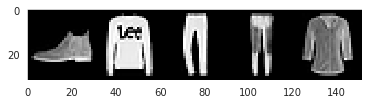

In [0]:
fmnist_sample, fmnist_target = iter(test_loader).next()
fmnist_sample = fmnist_sample.to(DEVICE)
print(fmnist_target)
sns.set_style("dark")
show(make_grid(fmnist_sample.cpu()))

Instead of just combining the outputs of samples from our model, we can instead graph a histogram of each sample’s individual prediction. By doing so we can now visualize our model’s uncertainty on the following five entries from the FMNIST test set:

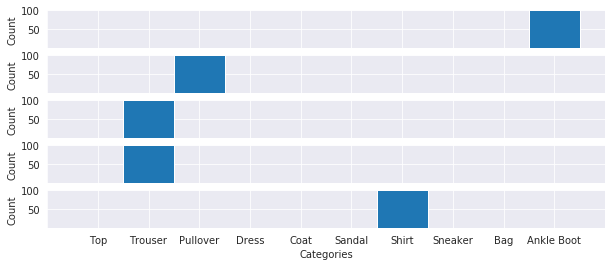

In [0]:
net.eval()
fmnist_outputs = net(fmnist_sample, True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    fmnist_outputs = np.append(fmnist_outputs, net(fmnist_sample, True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)
sns.set_style("darkgrid")
plt.subplots(5,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(fmnist_outputs[i], np.arange(-0.5, 10, 1))

#### Out-of-domain uncertainty 

### Exercise 

Use some MNIST samples as OOD data to test the behavior of our BNN similarly as above.